In [1]:
import torch
from STGCN.net import ST_GCN
Model = ST_GCN

In [2]:
joint_index_map = {
            "Pelvis": 0,
            "SpineNavel": 1,
            "SpineChest": 2,
            "Neck": 3,
            "ClavicleLeft": 4,
            "ShoulderLeft": 5,
            "ElbowLeft": 6,
            "WristLeft": 7,
            "HandLeft": 8,
            "HandTipLeft": 9,
            "ThumbLeft": 10,
            "ClavicleRight": 11,
            "ShoulderRight": 12,
            "ElbowRight": 13,
            "WristRight": 14,
            "HandRight": 15,
            "HandTipRight": 16,
            "ThumbRight": 17,
            "HipLeft": 18,
            "KneeLeft": 19,
            "AnkleLeft": 20,
            "FootLeft": 21,
            "HipRight": 22,
            "KneeRight": 23,
            "AnkleRight": 24,
            "FootRight": 25,
            "Head": 26,
            "Nose": 27,
            "EyeLeft": 28,
            "EarLeft": 29,
            "EyeRight": 30,
            "EarRight": 31
            }

joints = {
    "Pelvis": (0, 0),
    "SpineNavel": (0, 1),
    "SpineChest": (0, 2),
    "Neck": (0, 3),
    "ClavicleLeft": (-1, 3),
    "ShoulderLeft": (-2, 2.7),
    "ElbowLeft": (-3, 1.5),
    "WristLeft": (-3.5, 0),
    "HandLeft": (-4, -0.5),
    "HandTipLeft": (-4.5, -0.25),
    "ThumbLeft": (-4, 0.25),
    "ClavicleRight": (1, 3),
    "ShoulderRight": (2, 2.7),
    "ElbowRight": (3, 1.5),
    "WristRight": (3.5, 0),
    "HandRight": (4, -0.5),
    "HandTipRight": (4.5, -0.25),
    "ThumbRight": (4, 0.25),
    "HipLeft": (-1, -1),
    "KneeLeft": (-1.5, -3),
    "AnkleLeft": (-1.5, -5),
    "FootLeft": (-2, -5.5),
    "HipRight": (1, -1),
    "KneeRight": (1.5, -3),
    "AnkleRight": (1.5, -5),
    "FootRight": (2, -5.5),
    "Head": (0, 4),
    "Nose": (0, 4.5),
    "EyeLeft": (-0.5, 4.5),
    "EarLeft": (-1, 4),
    "EyeRight": (0.5, 4.5),
    "EarRight": (1, 4),
}

# Define the edges connecting the joints
edges = [
    ("Pelvis", "SpineNavel"), ("SpineNavel", "SpineChest"), ("SpineChest", "Neck"), ("Neck", "Head"),
    ("Head", "Nose"), ("Nose", "EyeLeft"), ("Nose", "EyeRight"), ("EyeLeft", "EarLeft"), ("EyeRight", "EarRight"),
    ("Neck", "ClavicleLeft"), ("ClavicleLeft", "ShoulderLeft"), ("ShoulderLeft", "ElbowLeft"), 
    ("ElbowLeft", "WristLeft"), ("WristLeft", "HandLeft"), ("HandLeft", "HandTipLeft"), ("WristLeft", "ThumbLeft"),
    ("Neck", "ClavicleRight"), ("ClavicleRight", "ShoulderRight"), ("ShoulderRight", "ElbowRight"), 
    ("ElbowRight", "WristRight"), ("WristRight", "HandRight"), ("HandRight", "HandTipRight"), ("WristRight", "ThumbRight"),
    ("Pelvis", "HipLeft"), ("HipLeft", "KneeLeft"), ("KneeLeft", "AnkleLeft"), ("AnkleLeft", "FootLeft"),
    ("Pelvis", "HipRight"), ("HipRight", "KneeRight"), ("KneeRight", "AnkleRight"), ("AnkleRight", "FootRight")
]

/tmp/ipykernel_1277236/2348632627.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'bo-', linewidth=6, markersize=10,color="blue", mfc="orange")


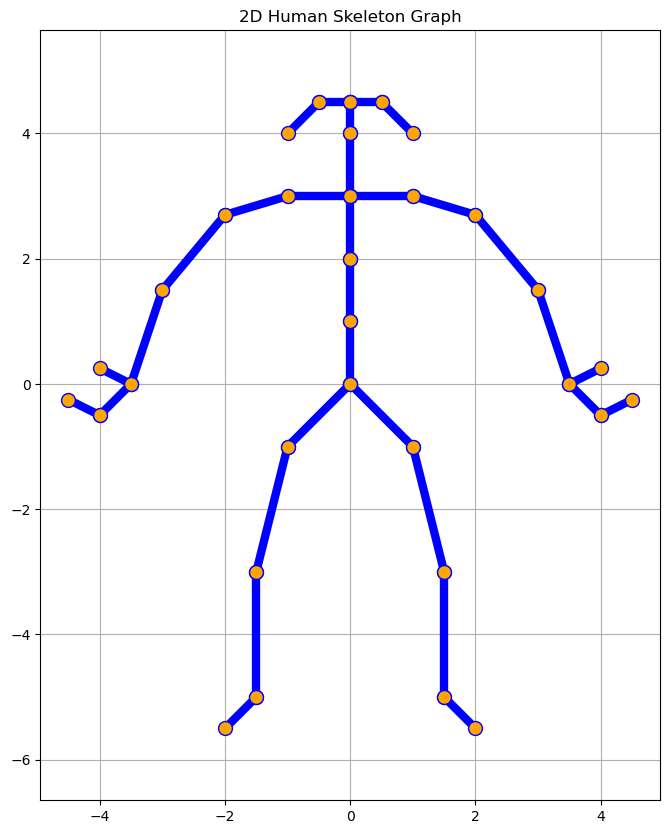

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))

for edge in edges:
    joint1, joint2 = edge
    x_values = [joints[joint1][0], joints[joint2][0]]
    y_values = [joints[joint1][1], joints[joint2][1]]

    plt.plot(x_values, y_values, 'bo-', linewidth=6, markersize=10,color="blue", mfc="orange")
# Adjust the plot
plt.title("2D Human Skeleton Graph")
plt.axis('equal')

plt.grid(True)
plt.show()

In [4]:
weights = torch.load("work_dir/train_gait_pd_v1/epoch150_gait_model.pt", weights_only=True)

from collections import OrderedDict
from sklearn.preprocessing import minmax_scale

pd_weights = OrderedDict(
                [[k.split('module.')[-1],
                  v] for k, v in weights.items()])
pd_skeleton_mask = {}
pd_joint_weight = {}

for idx, layer in enumerate(pd_weights):
    if layer.endswith("mask"):
        pd_skeleton_mask[layer] = minmax_scale(pd_weights[layer][1:].sum(axis=0), (0,1))
        pd_joint_weight[layer] = minmax_scale(pd_weights[layer][0].sum(axis=1), (0,1))

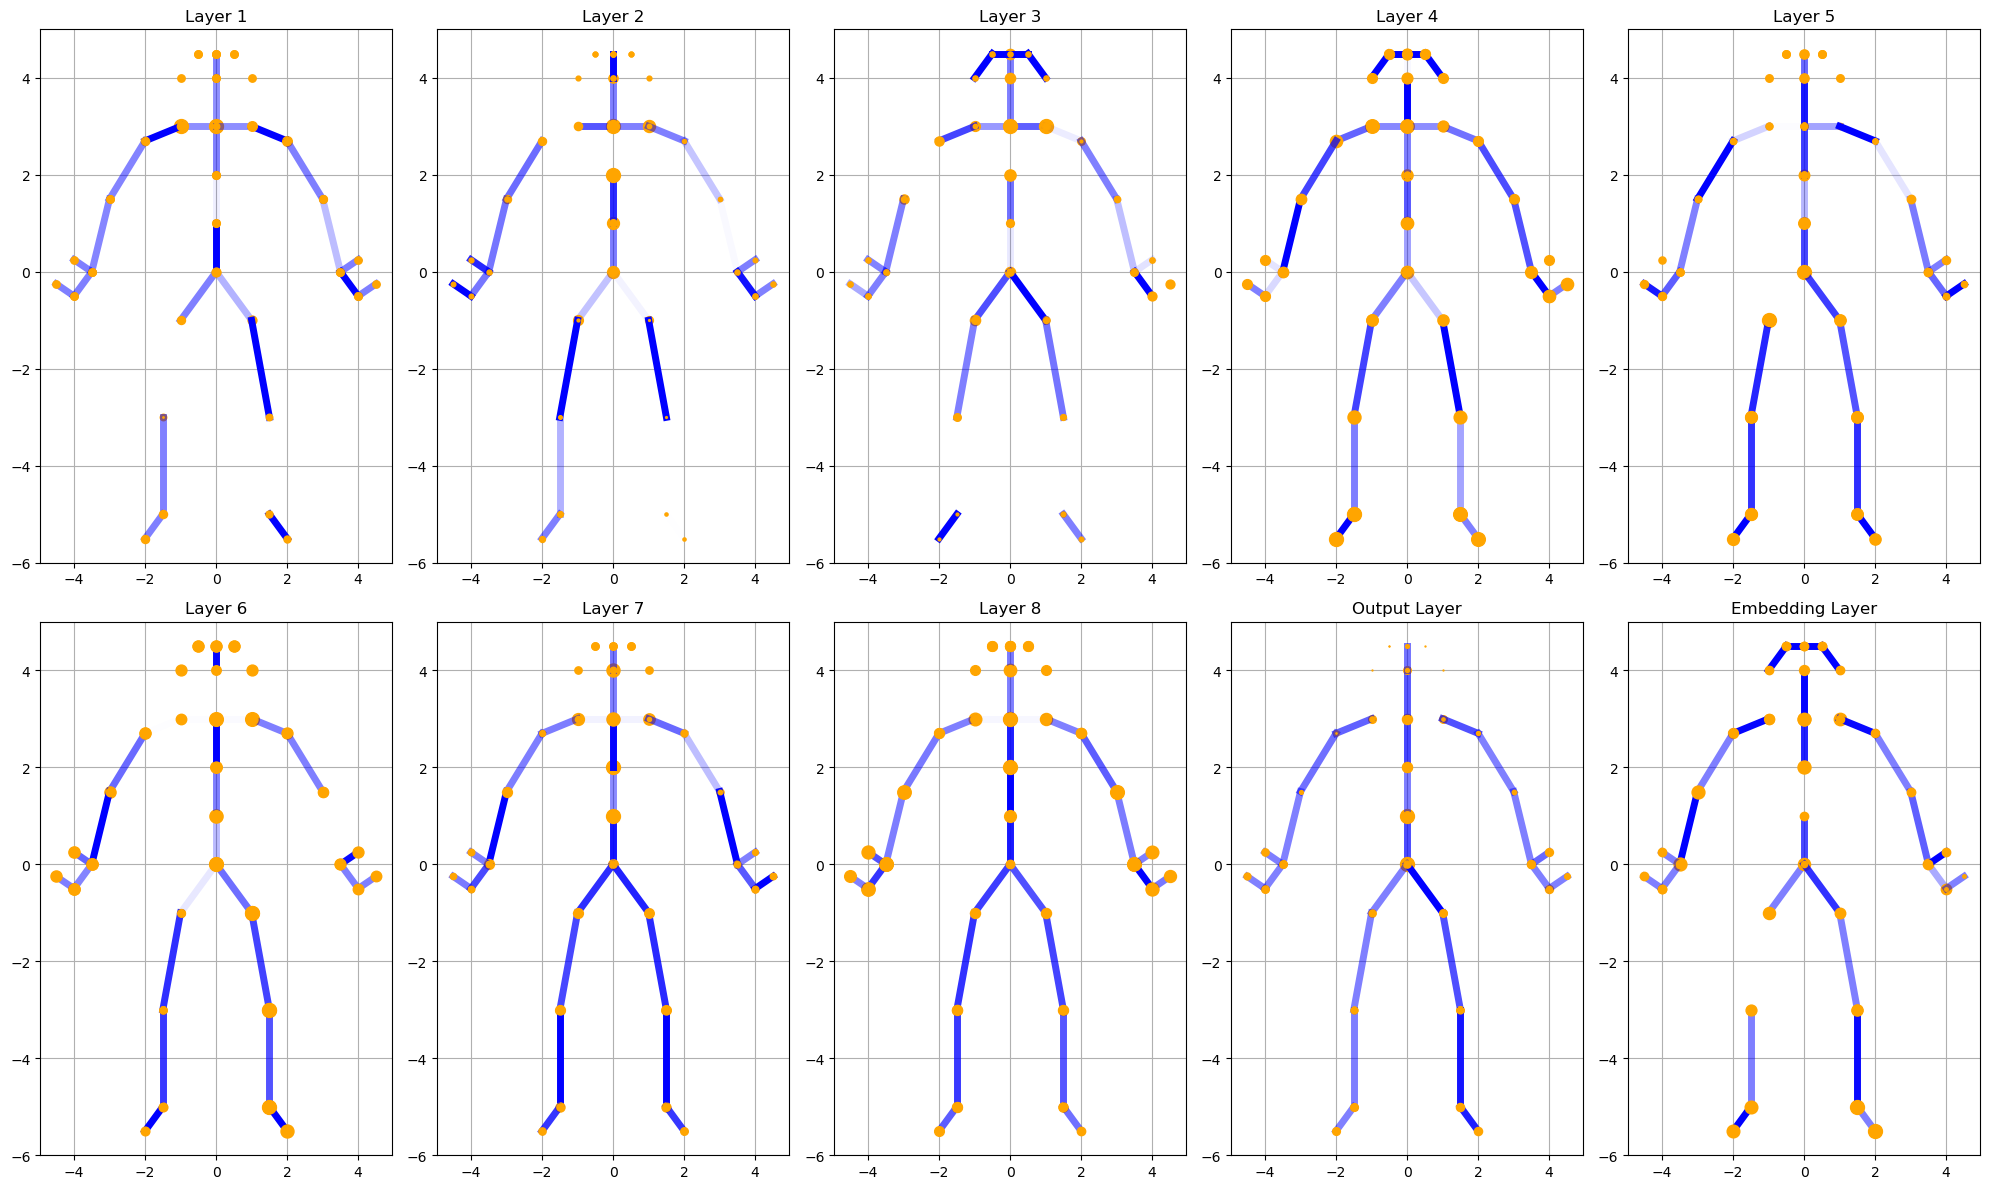

In [5]:

# Plot the graph
fig, axs = plt.subplots(ncols=5,nrows=2, figsize=(20, 12))
# Plot edges
for idx, layer in enumerate(pd_skeleton_mask.keys()):
    done_joint = []
    for edge in edges:
        joint1, joint2 = edge
        x_values = [joints[joint1][0], joints[joint2][0]]
        y_values = [joints[joint1][1], joints[joint2][1]]

        line_weight = pd_skeleton_mask[layer][joint_index_map[joint1], joint_index_map[joint2]]
        line_weight += pd_skeleton_mask[layer][joint_index_map[joint2], joint_index_map[joint1]]

        if joint1 not in done_joint:
            marker_weight = pd_joint_weight[layer][joint_index_map[joint1]]
            done_joint.append(joint1)
        elif joint2 not in done_joint:
            marker_weight = pd_joint_weight[layer][joint_index_map[joint2]]
            done_joint.append(joint2)
        else:
            continue

        ax = axs[idx//5, idx%5] 
        ax.plot(x_values, y_values, '-', linewidth=5,  alpha=line_weight/2, color="blue")
        ax.scatter(x_values, y_values, color="orange", zorder=2, s=marker_weight*100)
        # ax.set_axis('equal')
        if idx==8:
            ax.set_title(f"Output Layer")
        elif idx==9:
            ax.set_title(f"Embedding Layer")
        else:
            ax.set_title(f"Layer {idx+1}")
        ax.grid(True)

plt.tight_layout()
plt.savefig("pd_weights.png", dpi=200)
plt.show()

In [6]:
weights = torch.load("work_dir/train_gait_hc_v1/best_gait_model.pt", weights_only=True)

from collections import OrderedDict
from sklearn.preprocessing import minmax_scale

hc_weights = OrderedDict(
                [[k.split('module.')[-1],
                  v] for k, v in weights.items()])
hc_skeleton_mask = {}
hc_joint_weight = {}

for idx, layer in enumerate(hc_weights):
    if layer.endswith("mask"):
        hc_skeleton_mask[layer] = minmax_scale(weights[layer][1:].sum(axis=0), (0,1))
        hc_joint_weight[layer] = minmax_scale(weights[layer][0].sum(axis=1), (0,1))

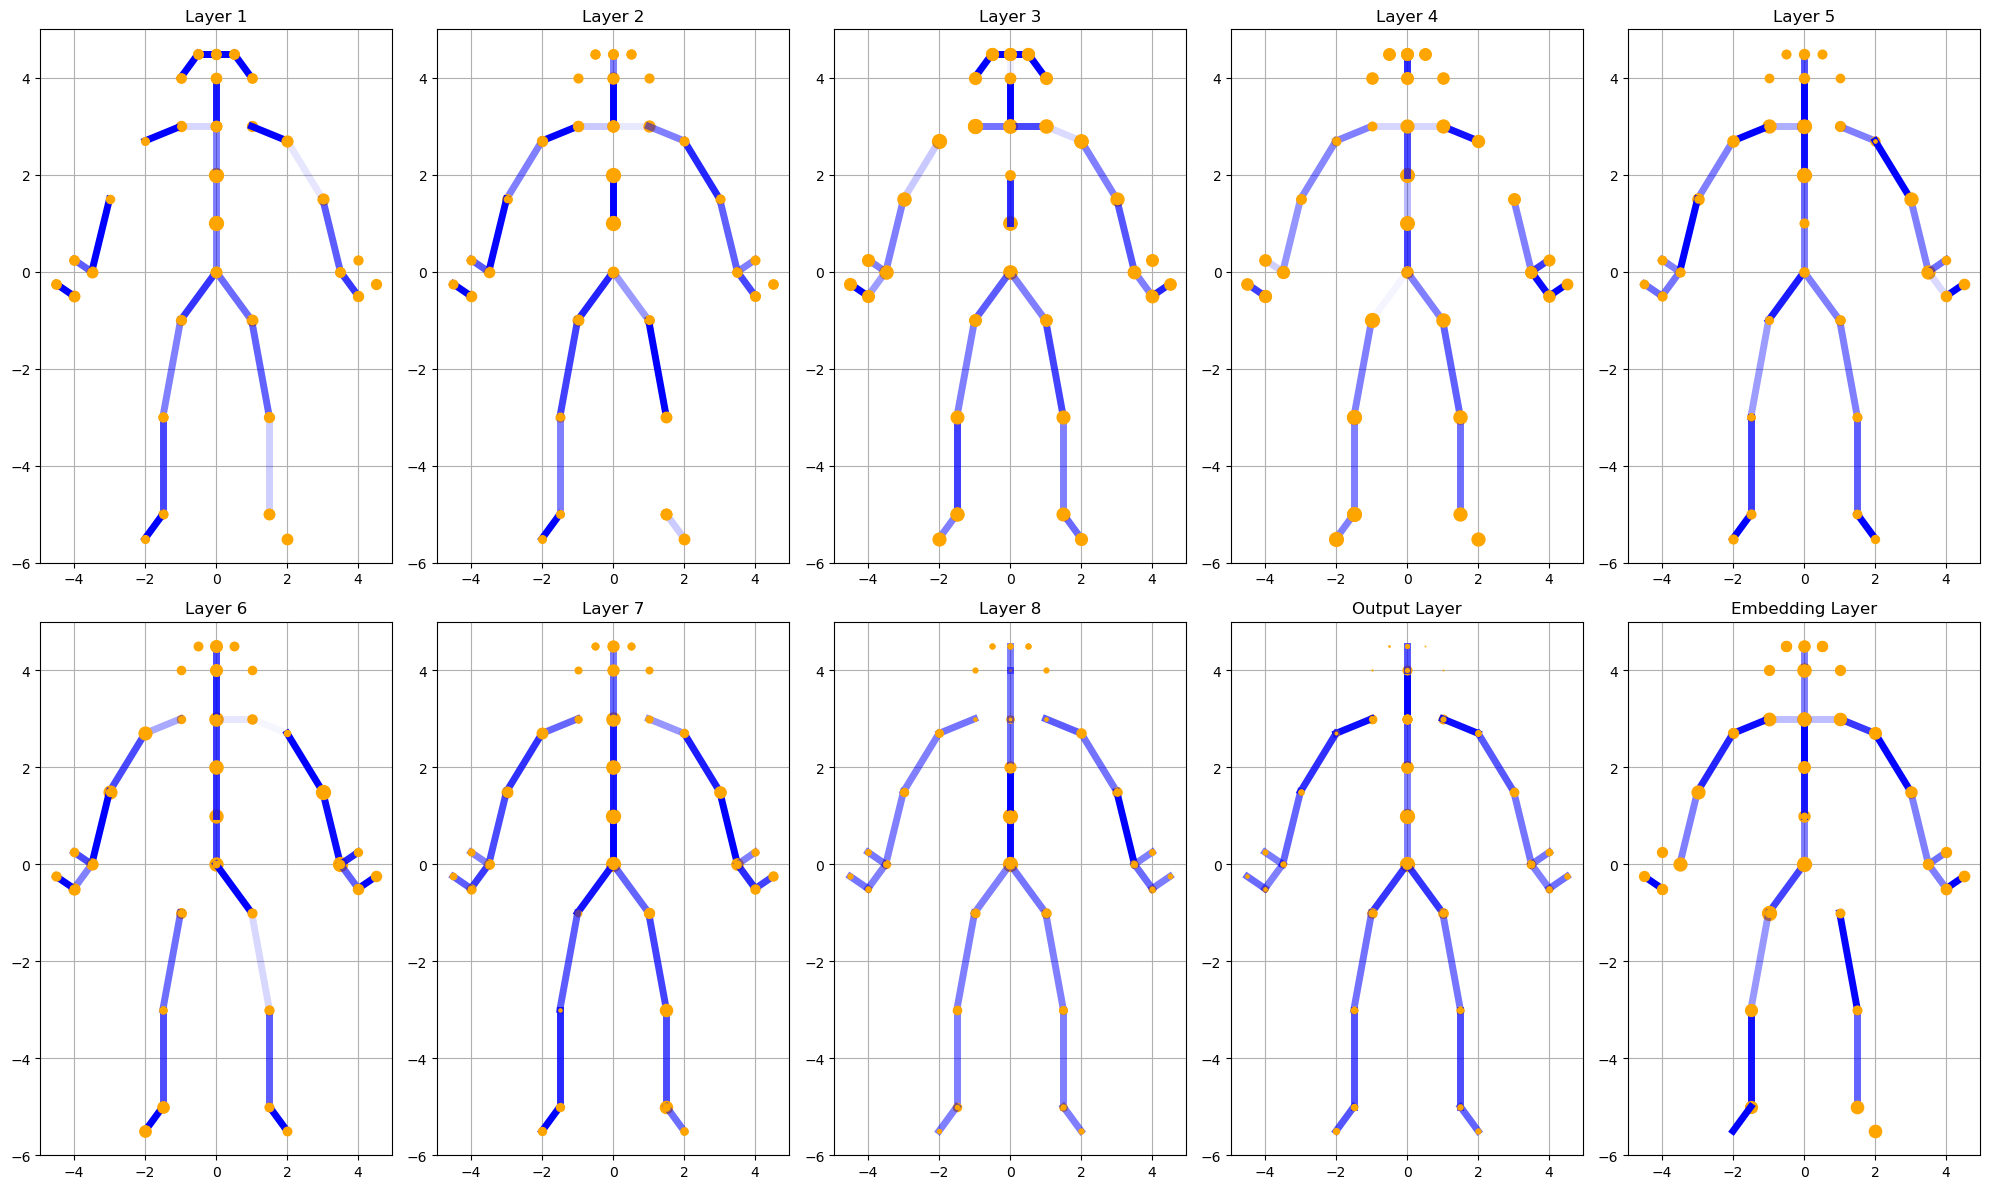

In [7]:

# Plot the graph
fig, axs = plt.subplots(ncols=5,nrows=2, figsize=(20, 12))
# Plot edges
for idx, layer in enumerate(hc_skeleton_mask.keys()):
    done_joint = []
    for edge in edges:
        joint1, joint2 = edge
        x_values = [joints[joint1][0], joints[joint2][0]]
        y_values = [joints[joint1][1], joints[joint2][1]]

        line_weight = hc_skeleton_mask[layer][joint_index_map[joint1], joint_index_map[joint2]]
        line_weight += hc_skeleton_mask[layer][joint_index_map[joint2], joint_index_map[joint1]]

        if joint1 not in done_joint:
            marker_weight = hc_joint_weight[layer][joint_index_map[joint1]]
            done_joint.append(joint1)
        elif joint2 not in done_joint:
            marker_weight = hc_joint_weight[layer][joint_index_map[joint2]]
            done_joint.append(joint2)
        else:
            continue

        ax = axs[idx//5, idx%5] 
        ax.plot(x_values, y_values, '-', linewidth=5,  alpha=min(line_weight/2, 1), color="blue")
        ax.scatter(x_values, y_values, color="orange", zorder=2, s=marker_weight*100)
        # ax.set_axis('equal')
        if idx==8:
            ax.set_title(f"Output Layer")
        elif idx==9:
            ax.set_title(f"Embedding Layer")
        else:
            ax.set_title(f"Layer {idx+1}")
        ax.grid(True)

plt.tight_layout()
plt.savefig("hc_weights.png", dpi=200)
plt.show()